---

### Recurrent Neural Network

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
data = fetch_20newsgroups(remove=['headers', 'footers'])

In [3]:
data['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
categories = ['soc.religion.christian', 'talk.politics.guns']

In [5]:
data = fetch_20newsgroups(categories=categories, remove=['headers', 'footers'])

In [6]:
X = data['data']

In [7]:
# X[0] - checked content = christianity. 0 MEANS christianity, 1 MEANS guns

In [8]:
y = data['target']

In [9]:
y[:10]  # 0's christian, 1's guns

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1])

### Text preprocessing 

* split 
* drop special characters and stop words
* tokenisation
* vectorize = we'll use keras embedding layer for that

In [10]:
def clean_text(text,label,cap):
    clean_text = []
    clean_label = []
    for i, email in enumerate(text):
        email = email.lower()
        email = re.findall('(?u)\\b\\w\\w+\\b', email)
        if len(email) <= cap:
            clean_text.append(email)
            clean_label.append(label[i])
    return clean_text, clean_label

In [11]:
sorted([len(x) for x in X])[-1]  #longest e-mail

70849

In [12]:
sorted([len(x) for x in X])[0]  #shortest e-mail

13

We could split the long e-mails or we could drop them.


Better not to lose data, but I want my model to train fast

In [13]:
clean_X, clean_y = clean_text(X, y, 300)

#### Make a vocab list

In [14]:
vocab_list = []
for email in clean_X:
    for word in email:
        vocab_list.append(word)
        
vocab_list = list(set(vocab_list))
vocab_size = len(vocab_list) + 1

#### Make a dictionary for words to numbers and back again

In [15]:
word_to_num = {}

for i, word in enumerate(vocab_list):
    word_to_num[word] = i+1 #i+1 because we're reserving 0 for blank space

In [16]:
word_to_num['christian']

4054

In [38]:
vec_X = [[word_to_num[word] for word in email] for email in clean_X]

#### find the max length of the text, then pad all seqeunces to match that length - input shape in NN has to be consistent!!

In [39]:
max_len = 0
position = 0
for i, email in enumerate(clean_X):
    if len(email) > max_len:
        max_len = len(email)
        position = i
max_len, position

(299, 82)

#### Lets pad the sequences

In [40]:
pad_vec_X = sequence.pad_sequences(vec_X, maxlen=max_len, padding='pre')

---

#### This is what we've done in RNNs so far
* download test emails
* removed special characters
* transformed the words into numbers
* cast them into a list
* padded them with zeroes so every email number list has the same length

#### This is what we have to do now
* initialise an lstm
* train in on the Xtrain data 
* test it on our Xtest data

In [41]:
from sklearn.model_selection import train_test_split

In [54]:
Xtrain, Xtest, ytrain, ytest = train_test_split(pad_vec_X, np.array(clean_y))

---

#### Now lets create the model
We build a sequential model

Then add an Embedding layer

This layer takes 3 parameters - the size of the vocab (input_dims), the no. of dimensions of each word embedding (output_dim), and the length of each document (input_length), which we've standardised above. It returns a 2d matrix, with rows equal to each word in the document, and columns equal to the number of dimensions in the word embedding. 

*Actually its 3D, cos the batch_size is the first dimension in both input and output, but I find that confuses things more than it clarifies*
Put another way 

The embedding **takes in** a factorized corpus, e.g.:

**[The, cat, sat, on, the, mat]**    becomes    **[1,2,3,4,1,5]**

And **outputs** a word embedded corpus:

**[1,2,3,4,1,5]**    becomes (lets assume output_dim=2)   **[[0.2,0.7], [0.6,0.3], [0.1,0.8], [0.2,0.1], [0.4,0.9], [0.2,0.7]]**

In [55]:
model = Sequential()

In [56]:
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len))

In [57]:
model.add(LSTM(128))  #units? if no.units > max_len, likely to overfit

In [58]:
model.add(Dense(1, activation='sigmoid'))

---

In [59]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
history = model.fit(Xtrain,ytrain,epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 2s 214ms/step - loss: 0.6926 - accuracy: 0.5219 - val_loss: 0.6900 - val_accuracy: 0.4737
Epoch 2/10
8/8 [==============================] - 1s 173ms/step - loss: 0.9358 - accuracy: 0.6382 - val_loss: 0.6752 - val_accuracy: 0.5263
Epoch 3/10
8/8 [==============================] - 1s 176ms/step - loss: 0.6522 - accuracy: 0.6798 - val_loss: 0.6943 - val_accuracy: 0.5263
Epoch 4/10
8/8 [==============================] - 1s 171ms/step - loss: 0.4774 - accuracy: 0.8048 - val_loss: 0.4128 - val_accuracy: 0.8860
Epoch 5/10
8/8 [==============================] - 1s 168ms/step - loss: 0.4930 - accuracy: 0.9167 - val_loss: 0.4446 - val_accuracy: 0.8070
Epoch 6/10
8/8 [==============================] - 1s 175ms/step - loss: 0.3156 - accuracy: 0.9496 - val_loss: 0.6169 - val_accuracy: 0.7895
Epoch 7/10
8/8 [==============================] - 1s 186ms/step - loss: 0.5080 - accuracy: 0.9759 - val_loss: 0.5465 - val_accuracy: 0.8158
Epoch 8/10
8/8 [====

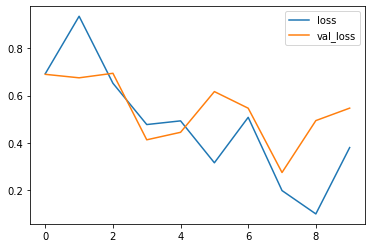

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

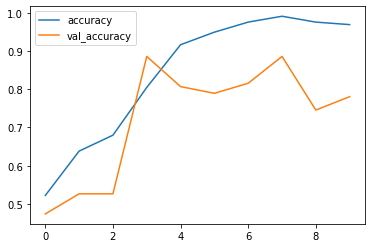

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [63]:
model.evaluate(Xtest,ytest)

6/6 [==============================] - 0s 32ms/step - loss: 0.5431 - accuracy: 0.8482


[0.5430743098258972, 0.8481675386428833]

#### Conclusion
* LSTM are v good on sequential data BUT
* Overfit easily - how can treat for that?
* And they still suffer from - word sense disambiguation, long long term memory isn't captured